
# Graph Spectra

In this notebook we will cluster graphs. We will especially investigate graphs using the K-eigenvector algorithm proposed in [On Spectral Clustering: analysis and an algorithm](https://ai.stanford.edu/~ang/papers/nips01-spectral.pdf)


In [114]:
import numpy as np

def read_data(filepath):
    data = np.genfromtxt(filepath, delimiter=',')
    return data



In [115]:

def fiedler_clustering(A):
    # Compute degree matrix
    D = np.diag(A.sum(axis=1))
    
    # Compute unnormalized Laplacian
    L = D - A
    
    # Compute eigenvalues and eigenvectors
    eigvals, eigvecs = np.linalg.eigh(L)
    
    idx = np.argsort(eigvals)
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    
    fiedler_vector = eigvecs[:, 1]
    
    # If the fiedler vector is positive, we assign it to the positive cluster, otherwise to the negative cluster
    labels = (fiedler_vector >= 0).astype(int)
    
    return labels

# K-eigenvector algorithm

Given a set of points S:
1. Form affinity matrix A. Which captures the similarities of points S. Thus other similarity matricies like an adjacency matrix would be fine
2. Construct the Laplacian. L = D^(-1/2) A D^(-1/2), where D is the diagonal matrix with the sum of each row in A
3. Form X by k largest eigenvectors of L
4. Y = Normalize X
5. Cluster rows in Y
6. Assign clusters to points in S

In [116]:
from sklearn.cluster import KMeans

def spectral_clustering(A, k):       
    # normalized Laplacian L
    D_inv_sqrt = np.diag(1 / np.sqrt(A.sum(axis=1)))
    L = D_inv_sqrt @ A @ D_inv_sqrt

    # K Eigenvectors X
    eigvals, eigvecs = np.linalg.eigh(L)
    sorted_eigen_indices = np.argsort(eigvals)[-k:]
    X = eigvecs[:, sorted_eigen_indices]

    # Normalize X -> Y
    Y = X / np.linalg.norm(X, axis=1, keepdims=True)

    # K-Means Clustering on Y
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Y)
    cluster_labels = kmeans.labels_
    
    return cluster_labels

In [117]:
from scipy.sparse import csr_matrix

def edges_adjacency_matrix(E):
    col1 = E[:, 0].astype(int)
    col2 = E[:, 1].astype(int)
    max_ids = int(max(np.maximum(col1, col2)))
    As = csr_matrix((np.ones_like(col1), (col1-1, col2-1)), shape=(max_ids, max_ids))
    Adj = As.toarray()
    return Adj


In [118]:
import networkx as nx

def graph_to_affinity_matrix(G, sigma):
    distances = nx.floyd_warshall_numpy(G)
    A = np.exp(-distances**2 / (2 * sigma**2))
    np.fill_diagonal(A, 0)
    return A


In [68]:
E = read_data('data/example1.dat')
E2 = read_data('data/example2.dat')

In [69]:
import networkx as nx

G = nx.Graph()
G.add_edges_from(zip(E[:,0], E[:,1]))

G2 = nx.Graph()
G2.add_edges_from(zip(E2[:,0], E2[:,1]))


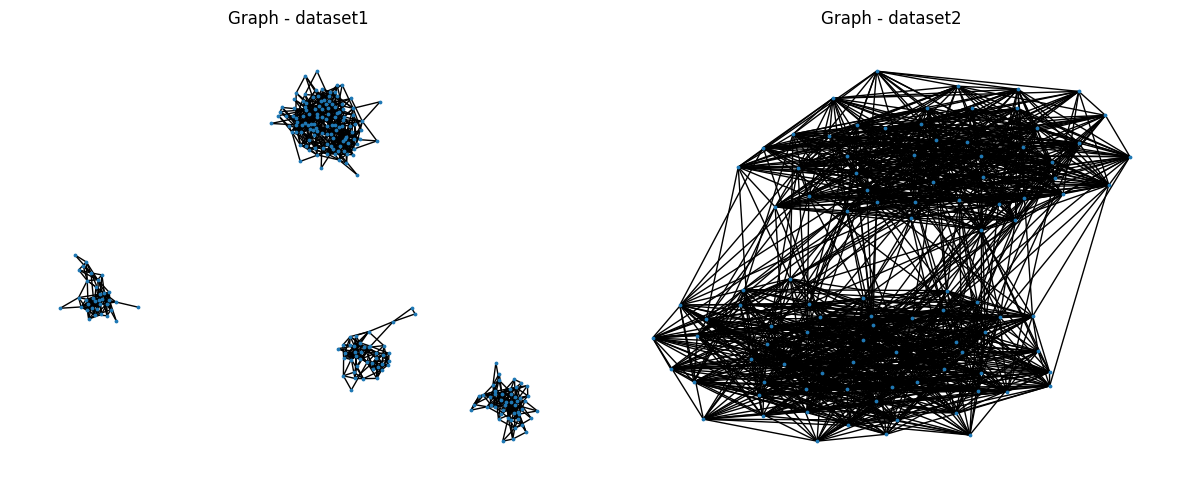

In [73]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot first graph
pos1 = nx.spring_layout(G)
nx.draw(G, pos1, node_size=3, ax=ax1)
ax1.set_title('Graph - dataset1')

# Plot second graph
pos2 = nx.spring_layout(G2)
nx.draw(G2, pos2, node_size=3, ax=ax2)
ax2.set_title('Graph - dataset2')

plt.tight_layout()
plt.show()



The datasets are plotted above

In [120]:

sigma = 1

A = edges_adjacency_matrix(E)
#A = graph_to_affinity_matrix(G, sigma) # the problem here is that we have to set sigma manually. The paper suggests a search to minimize the distortion on clusters given K. 


#A2 = graph_to_affinity_matrix(G2, sigma)
A2 = edges_adjacency_matrix(E2)

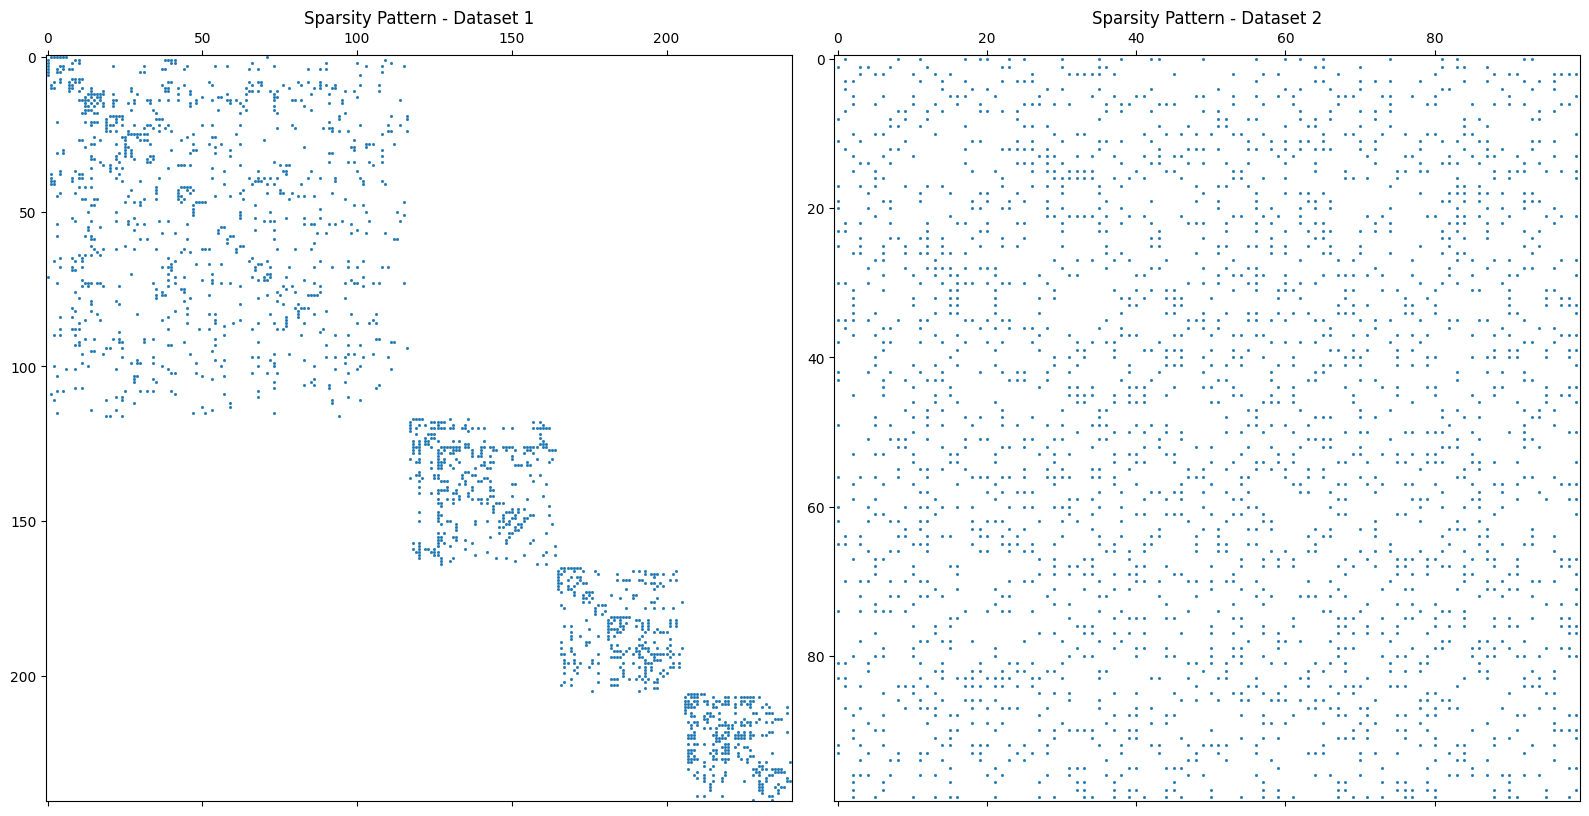

In [121]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot first sparsity pattern
ax1.spy(A, markersize=1)
ax1.set_title('Sparsity Pattern - Dataset 1')

# Plot second sparsity pattern
ax2.spy(A2, markersize=1)
ax2.set_title('Sparsity Pattern - Dataset 2')

plt.tight_layout()
plt.show()

Sparsity of the adjacency matricies

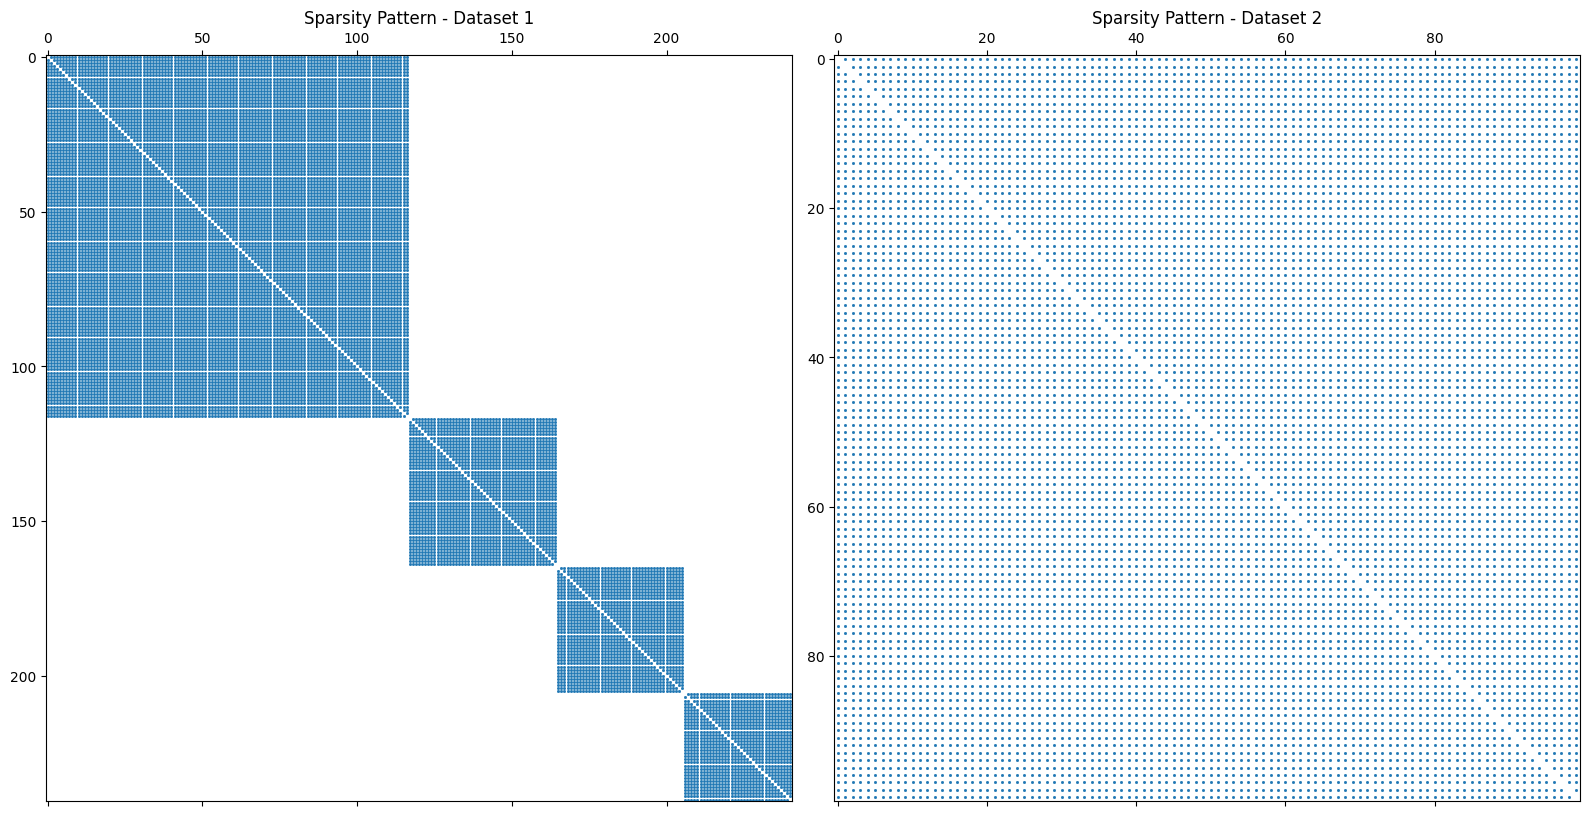

In [128]:
sigma = 1

A = graph_to_affinity_matrix(G, sigma) # the problem here is that we have to set sigma manually. The paper suggests a search to minimize the distortion on clusters given K. 


A2 = graph_to_affinity_matrix(G2, sigma)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot first sparsity pattern
ax1.spy(A, markersize=1)
ax1.set_title('Sparsity Pattern - Dataset 1')

# Plot second sparsity pattern
ax2.spy(A2, markersize=1)
ax2.set_title('Sparsity Pattern - Dataset 2')

plt.tight_layout()
plt.show()

Sparsity of the affinity matricies, based on the distances from nodes to each other. We can see that this is more structured than the adjacency matricies. This also has a big importance on how the clustering works later on. Especially for the second dataset. With the affinity matrix the the two main blobs in dataset forms their own clusters with k=2, while with the adjacency matrix the two clusters are divided equally. This also happens for the fiedler clustering.  

This can be explained by adjacency matrix only capturing binary relationships (connected/not connected), while the affinity matrix captures the strength of relationships through continuous values. This helps identify clusters that are "close" in the graph, not just directly connected. The use of similarity measures is thus important for the clustering. The paper is specifically using an affinity matrix. Sigma is a hyperparameter that can be found by search by minimizing the cluster distortion, as described in the experiments section in the original paper. 

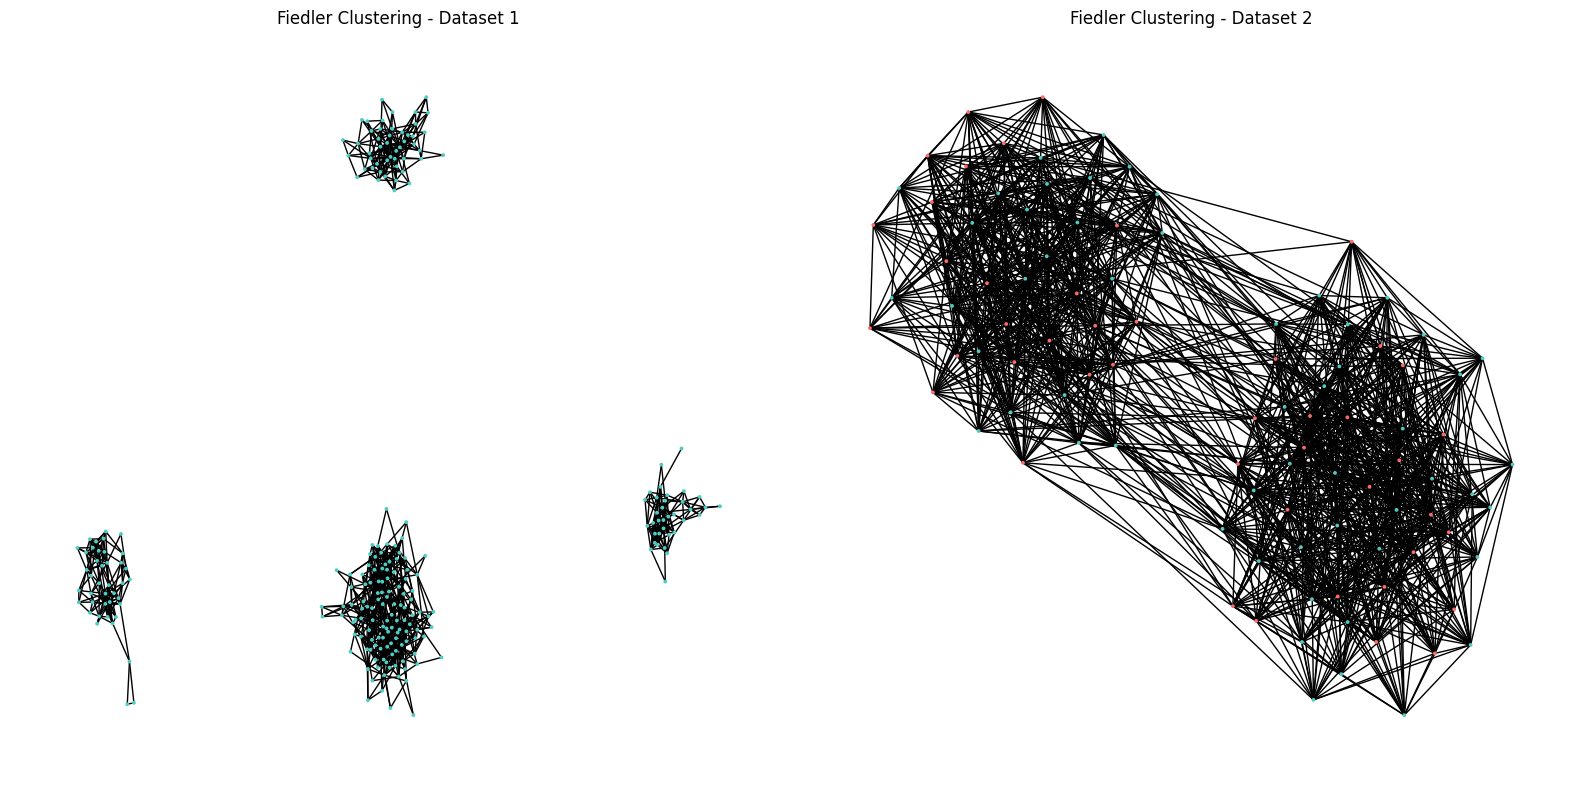

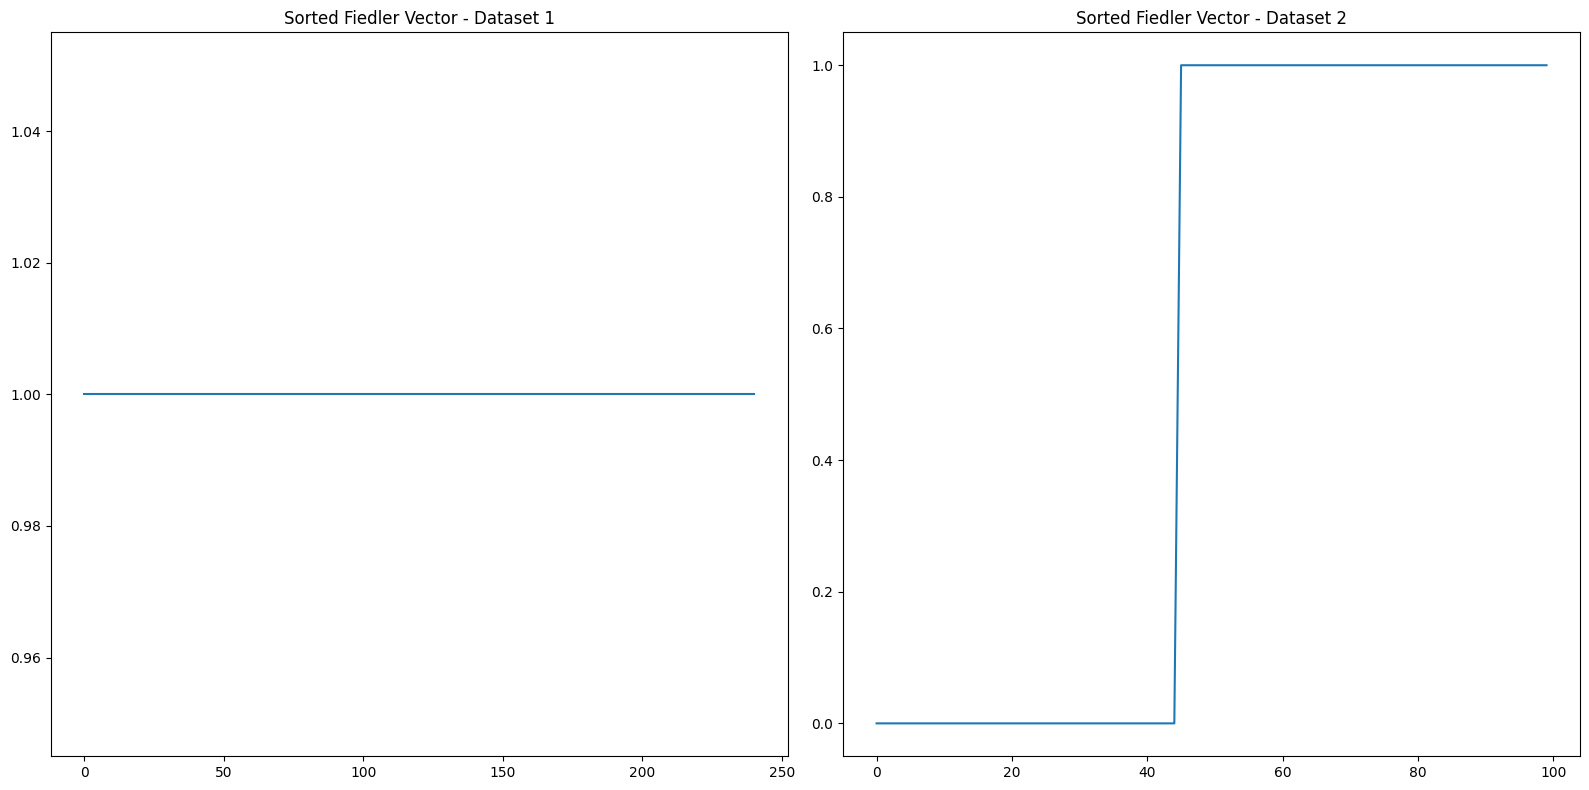

In [122]:
# Perform Fiedler clustering on both datasets
labels_fiedler1 = fiedler_clustering(A)
labels_fiedler2 = fiedler_clustering(A2)

# Create side-by-side visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot first graph
pos1 = nx.spring_layout(G)
colors = ['#FF6B6B', '#4ECDC4']  # Red and turquoise
nx.draw(G, pos1, node_color=[colors[idx] for idx in labels_fiedler1], 
        node_size=3, ax=ax1)
ax1.set_title('Fiedler Clustering - Dataset 1')

# Plot second graph
pos2 = nx.spring_layout(G2)
nx.draw(G2, pos2, node_color=[colors[idx] for idx in labels_fiedler2], 
        node_size=3, ax=ax2)
ax2.set_title('Fiedler Clustering - Dataset 2')

plt.tight_layout()
plt.show()

# Optional: Plot sorted Fiedler vectors for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.plot(np.sort(labels_fiedler1))
ax1.set_title('Sorted Fiedler Vector - Dataset 1')

ax2.plot(np.sort(labels_fiedler2))
ax2.set_title('Sorted Fiedler Vector - Dataset 2')

plt.tight_layout()
plt.show()

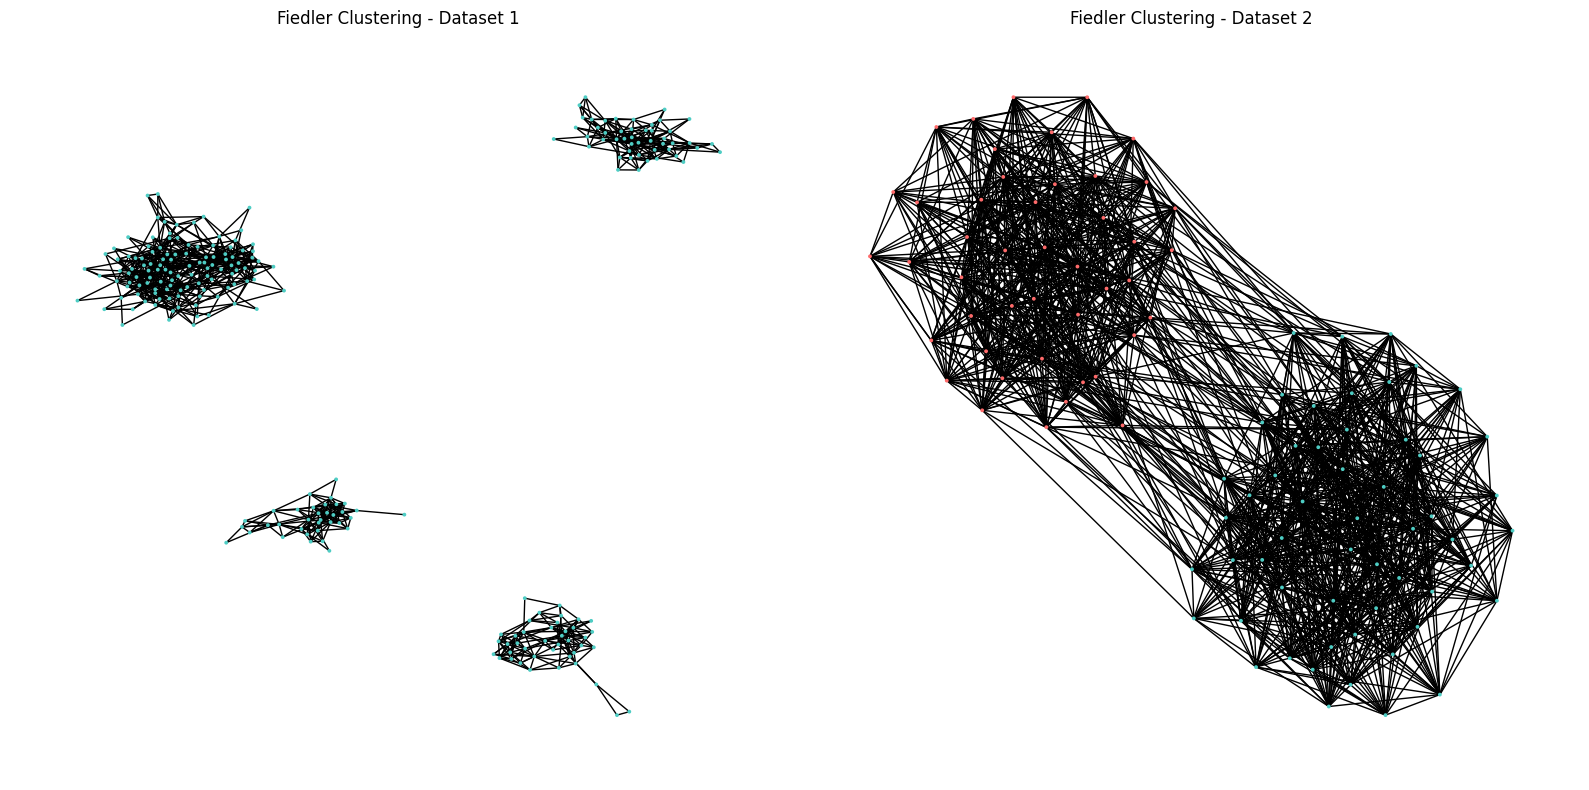

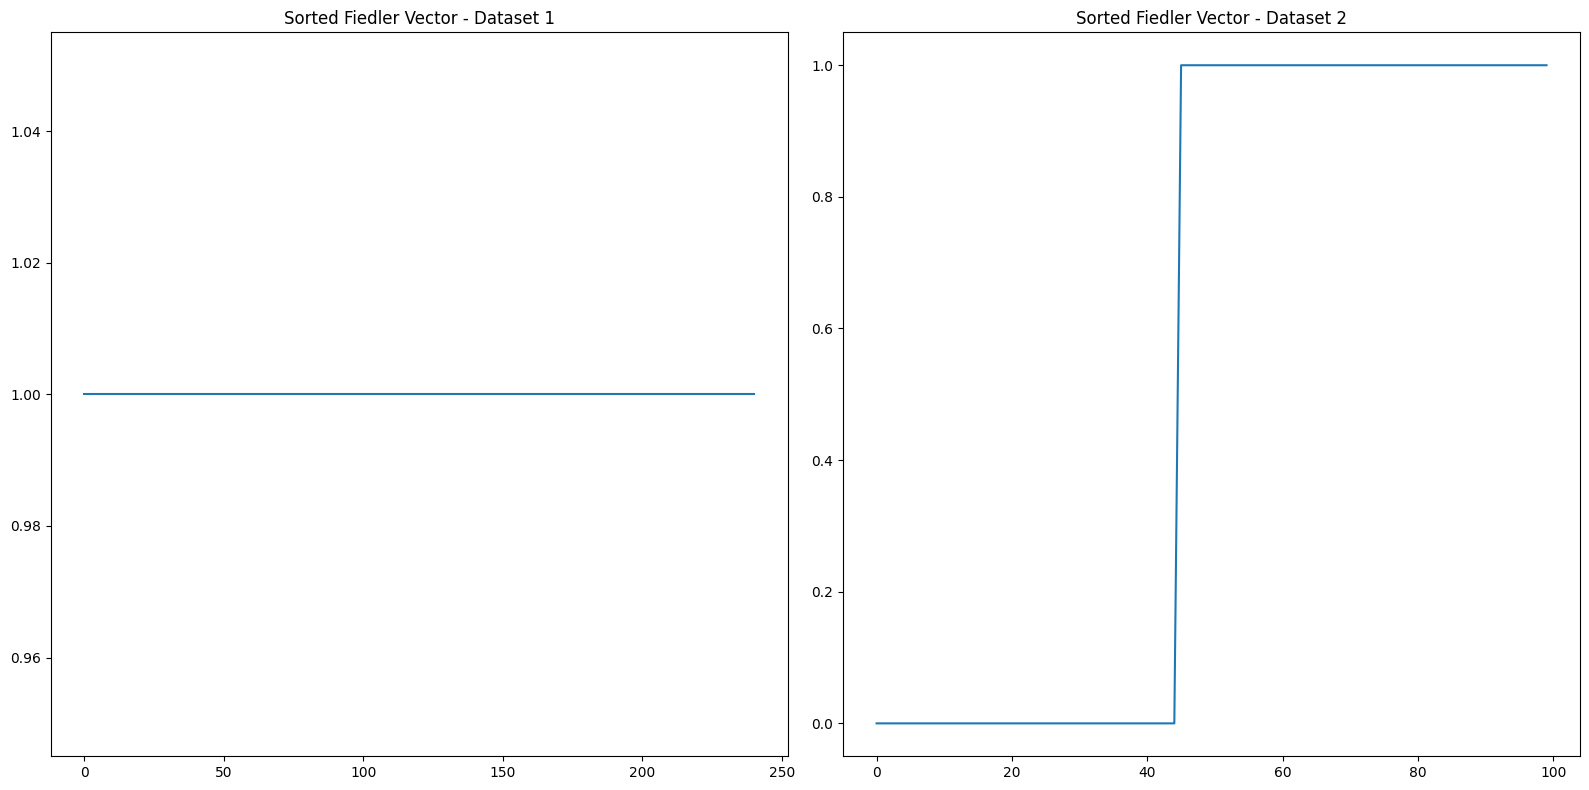

In [129]:
# Perform Fiedler clustering on both datasets
labels_fiedler1 = fiedler_clustering(A)
labels_fiedler2 = fiedler_clustering(A2)

# Create side-by-side visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot first graph
pos1 = nx.spring_layout(G)
colors = ['#FF6B6B', '#4ECDC4']  # Red and turquoise
nx.draw(G, pos1, node_color=[colors[idx] for idx in labels_fiedler1], 
        node_size=3, ax=ax1)
ax1.set_title('Fiedler Clustering - Dataset 1')

# Plot second graph
pos2 = nx.spring_layout(G2)
nx.draw(G2, pos2, node_color=[colors[idx] for idx in labels_fiedler2], 
        node_size=3, ax=ax2)
ax2.set_title('Fiedler Clustering - Dataset 2')

plt.tight_layout()
plt.show()

# Optional: Plot sorted Fiedler vectors for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.plot(np.sort(labels_fiedler1))
ax1.set_title('Sorted Fiedler Vector - Dataset 1')

ax2.plot(np.sort(labels_fiedler2))
ax2.set_title('Sorted Fiedler Vector - Dataset 2')

plt.tight_layout()
plt.show()

We can see that the fielder vector algorithm struggles to disect the first graph into its corresponding clusters for both As, while the other graph relatively efficiently is split into two clusters. 

Lets try use the K-eigenvector algorithm to cluster the graphs instead

In [130]:

k = 4
labels = spectral_clustering(A, k)
labels2 = spectral_clustering(A2, k)

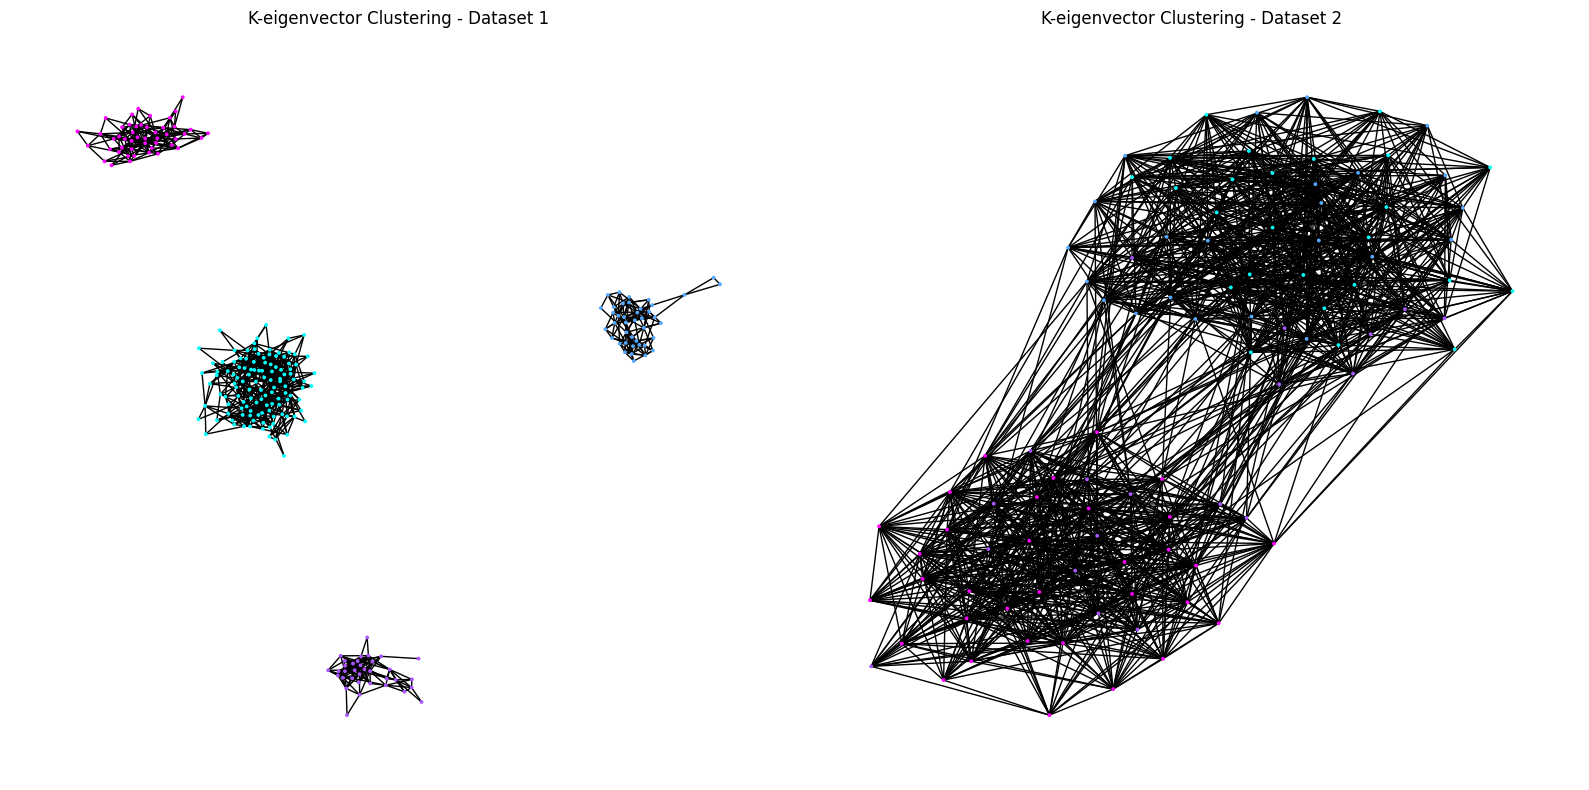

In [131]:
# Create side-by-side visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot first graph
pos1 = nx.spring_layout(G)
colors = plt.cm.cool(np.linspace(0, 1, k))
nx.draw(G, pos1, node_color=[colors[idx-1] for idx in labels], 
        node_size=3, ax=ax1)
ax1.set_title('K-eigenvector Clustering - Dataset 1')

# Plot second graph
pos2 = nx.spring_layout(G2)
nx.draw(G2, pos2, node_color=[colors[idx-1] for idx in labels2], 
        node_size=3, ax=ax2)
ax2.set_title('K-eigenvector Clustering - Dataset 2')

plt.tight_layout()
plt.show()

With the K-eigenvector algorithm, the first datasets cluster are identified with k=4. The second dataset is more difficult to cluster, especially with k=4. 
Lets do a k-analysis to find the appropriate k values based on the connectivity and GAP when removing/adding another eigenvalue


Analyzing Dataset 1:


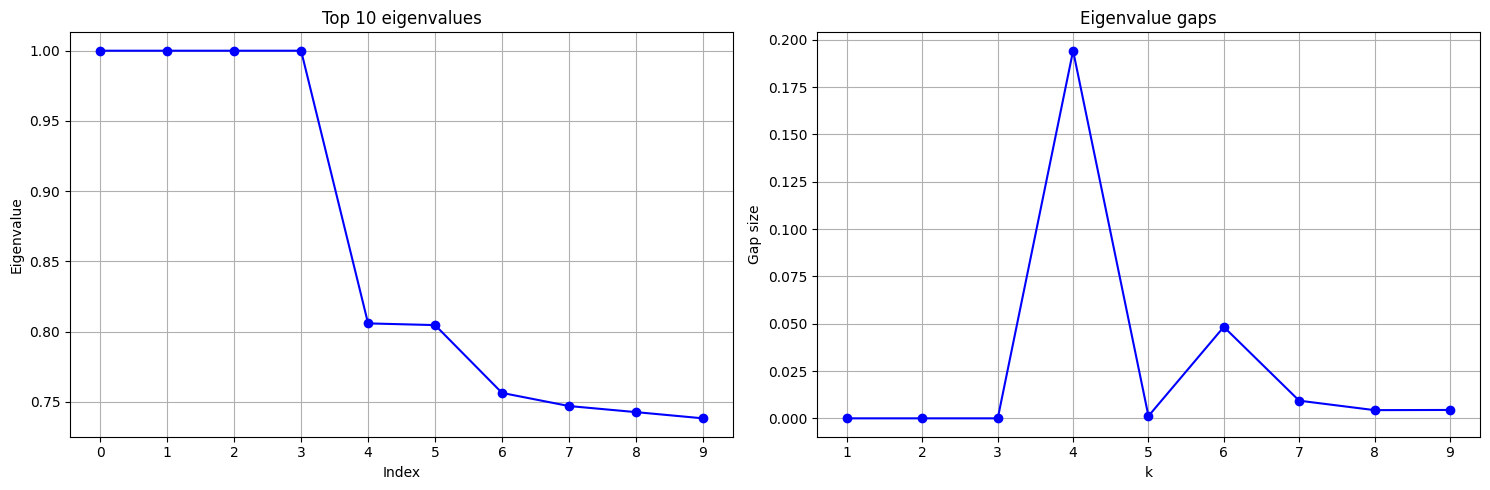


Analyzing Dataset 2:


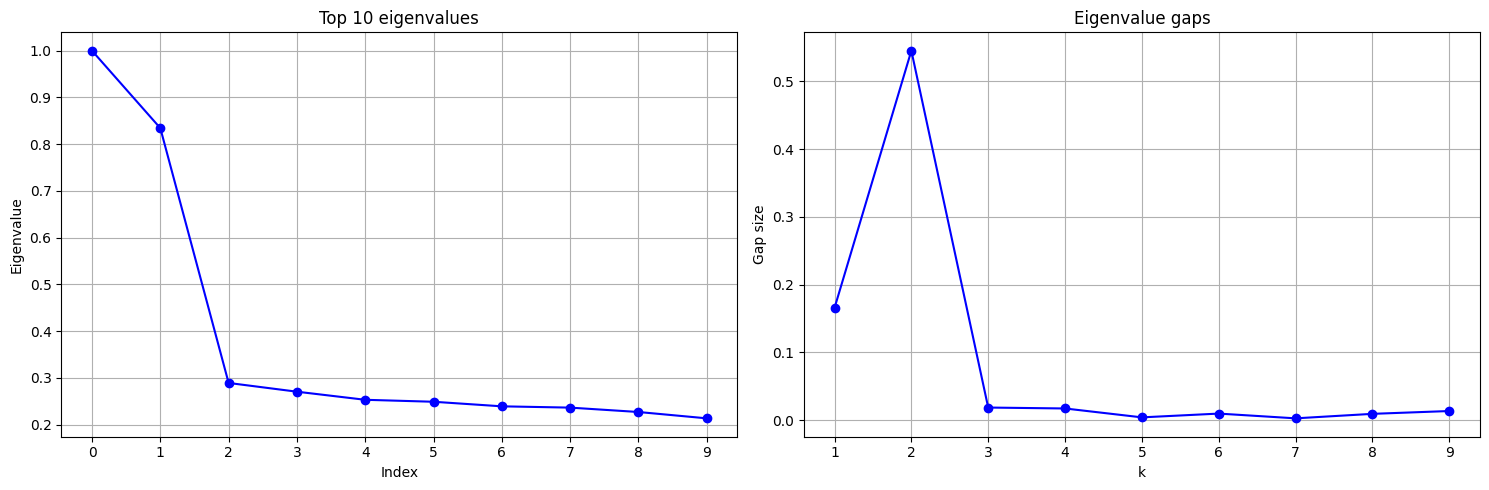

In [125]:
def find_optimal_k(A, max_k=10):
    # Compute normalized Laplacian
    D_inv_sqrt = np.diag(1 / np.sqrt(A.sum(axis=1)))
    L = D_inv_sqrt @ A @ D_inv_sqrt
    
    # Get eigenvalues
    eigvals, _ = np.linalg.eigh(L)
    # Sort in descending order
    eigvals = np.sort(eigvals)[::-1]
    
    # Calculate gaps between consecutive eigenvalues
    gaps = np.abs(np.diff(eigvals[:max_k]))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # First subplot: eigenvalues
    ax1.plot(eigvals[:max_k], 'bo-')
    ax1.grid(True)
    ax1.set_title(f'Top {max_k} eigenvalues')
    ax1.set_xlabel('Index')
    ax1.set_ylabel('Eigenvalue')
    ax1.set_xticks(range(max_k))
    
    # Second subplot: gaps
    ax2.plot(range(1, len(gaps) + 1), gaps, 'bo-')
    ax2.grid(True)
    ax2.set_title('Eigenvalue gaps')
    ax2.set_xlabel('k')
    ax2.set_ylabel('Gap size')
    
    plt.tight_layout()
    plt.show()

# Use it for both datasets
print("\nAnalyzing Dataset 1:")
find_optimal_k(A, max_k=10)

print("\nAnalyzing Dataset 2:")
find_optimal_k(A2, max_k=10)

Analyzing the eigenvalues we can see that the first dataset has 4 disconnected clusters (eigenvalue = 1) while the second has 1. The first also have a relatively high gap~0.1 between k=4 and k=5 suggesting that there is another relatively connected cluster within another cluster. Then in the second graph the biggest gap is between the only connected cluster and its second eigenvector. While the second to third eigenvector also has a quite big gap>0.3 suggesting that there's a cluster here. 

Based on this we'd probably wanna use k=4 for the first dataset and k=2 for the second. For interest we'll use k=5 for the first dataset to see what is going on in that part.  

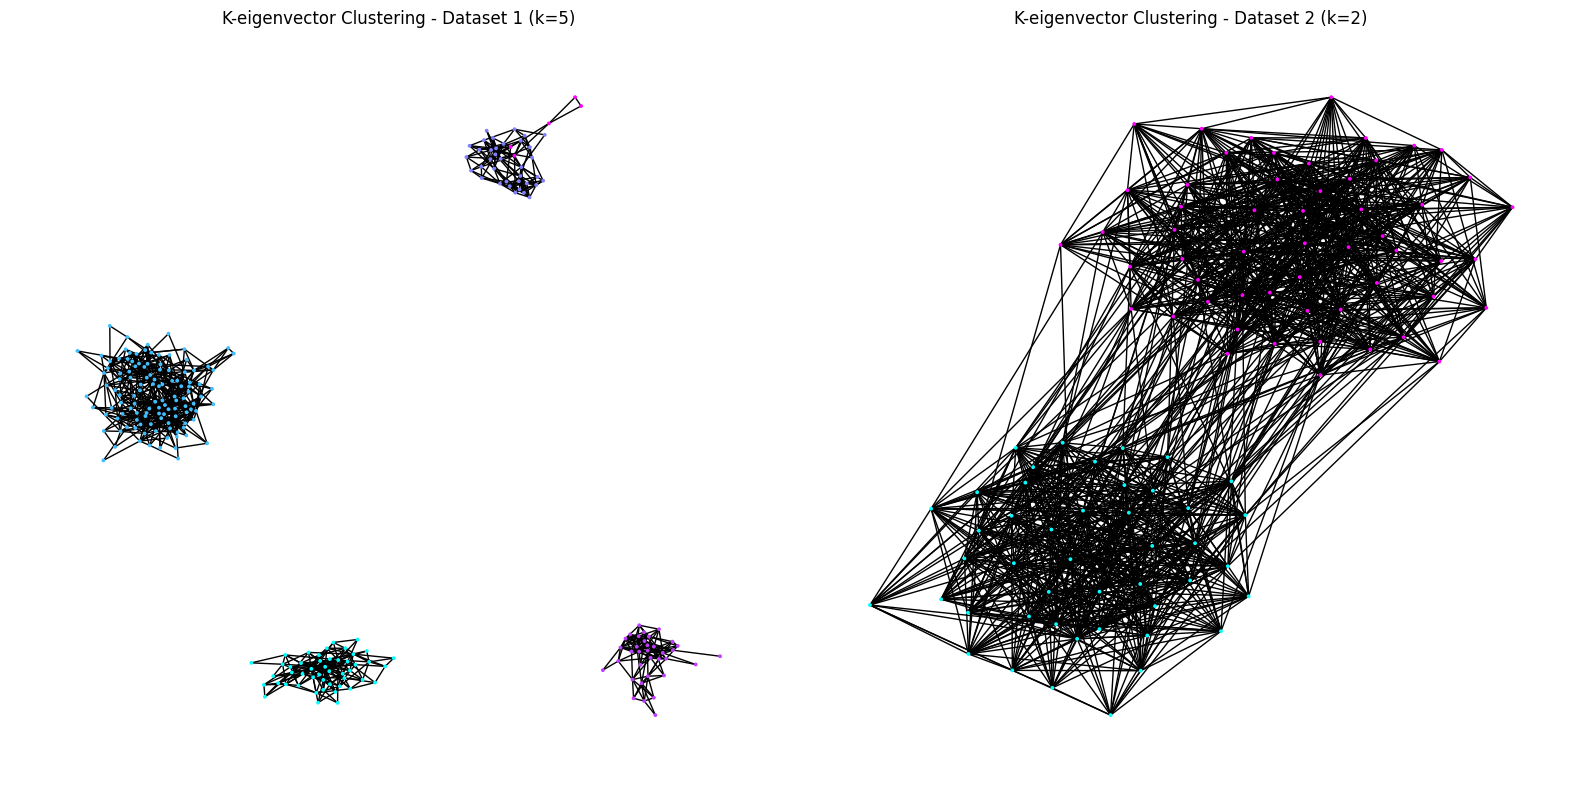

In [132]:
labels = spectral_clustering(A, k=5)
labels2 = spectral_clustering(A2, k=2)

# Create side-by-side visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot first graph (k=5)
pos1 = nx.spring_layout(G)
colors1 = plt.cm.cool(np.linspace(0, 1, 5))  # 5 colors for k=5
nx.draw(G, pos1, node_color=[colors1[idx] for idx in labels], 
        node_size=3, ax=ax1)
ax1.set_title('K-eigenvector Clustering - Dataset 1 (k=5)')

# Plot second graph (k=2)
pos2 = nx.spring_layout(G2)
colors2 = plt.cm.cool(np.linspace(0, 1, 2))  # 2 colors for k=2
nx.draw(G2, pos2, node_color=[colors2[idx] for idx in labels2], 
        node_size=3, ax=ax2)
ax2.set_title('K-eigenvector Clustering - Dataset 2 (k=2)')

plt.tight_layout()
plt.show()

Now we can see that the K-eigenvalue algorithm successfully have disected the graphs. Especially dataset 2 has gotten a nice division within the main cluster. We can also see that in dataset1 one of the clusters seems to have a few loosely connected points which are clustered together as a 5th cluster